## Modeling Stage of The Pursuit of Happiness: Exploring the DALI_Data-Anon data
### Logan Chang
### DALI Lab Coding Challenge

In this notebook, I build a classification model for the DALI_Data-Anon data for my application to the DALI Lab. After examining the raw data, I experiment with different classification algorithms from SciKit-Learn, tune a chosen model, and analyze its performance both analytically and visualy. This was also a great chance for me to learn about Genetic Programming and test an automated feature engineering algorithm to see if it improved the classifier's performance. To learn more about this algorithm and Genetic Programming in general, check out the documentation [here](https://gplearn.readthedocs.io/en/stable/index.html) for a popular GP library and the one I used.

In [1]:
#imports
from gplearn.genetic import SymbolicTransformer
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import (
    RandomForestClassifier,
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, make_scorer, balanced_accuracy_score, recall_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from yellowbrick.classifier import PrecisionRecallCurve
from sklearn import svm
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

## 1. Data Loading and Preprocessing

In [2]:
#load dataframe
df = pd.read_csv('/Users/logan/Desktop/DALI/DALI_Data_cleaned.csv')
df = df.drop(columns = 'Unnamed: 0')
df.head()

,year,gender,heightInches,happiness,stressed,sleepPerNight,socialDinnerPerWeek,alcoholDrinksPerWeek,caffeineRating,affiliated,numOfLanguages,gymPerWeek,hoursOnScreen,phoneType
0,'19,Female,63.0,4,2,7,3.0,4.0,1,Y,2,3.0,6.0,iOS
1,'19,Male,71.0,4,5,7,3.0,8.0,6,Y,2,4.0,6.0,iOS
2,'19,Female,63.0,4,4,7,3.0,2.0,1,Y,1,0.0,9.0,Other
3,'19,Male,70.0,4,5,7,7.0,7.0,8,Y,1,3.0,7.0,Android
4,'19,Male,70.0,4,8,7,3.0,3.0,3,Y,2,5.0,6.0,iOS


In [3]:
#make sure all our data is here
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 14 columns):
year                    66 non-null object
gender                  66 non-null object
heightInches            66 non-null float64
happiness               66 non-null int64
stressed                66 non-null int64
sleepPerNight           66 non-null int64
socialDinnerPerWeek     66 non-null float64
alcoholDrinksPerWeek    66 non-null float64
caffeineRating          66 non-null int64
affiliated              66 non-null object
numOfLanguages          66 non-null int64
gymPerWeek              66 non-null float64
hoursOnScreen           66 non-null float64
phoneType               66 non-null object
dtypes: float64(5), int64(5), object(4)
memory usage: 7.3+ KB


In [4]:
#encode non-numeric data
gender_switch = {'Male': 0, 'Female': 1, 'Other': 2}
affiliated_switch = {'Y': 1, 'N': 0}
phoneType_switch = {'iOS': 0, 'Android': 1, 'Other': 2}
df['year'] = df.apply(lambda row: int(row['year'][1:]), axis = 1)
df['gender'] = df.apply(lambda row: gender_switch[row['gender']], axis = 1)
df['affiliated'] = df.apply(lambda row: affiliated_switch[row['affiliated']], axis = 1)
df['phoneType'] = df.apply(lambda row: phoneType_switch[row['phoneType']], axis = 1)
categorical_names = ['year','gender','affiliated', 'phoneType']
numerical_names = np.setdiff1d(df.columns.tolist(), categorical_names)

In [5]:
#seperate features from target
y = df.pop('happiness')
X = df
classes = y.unique().tolist()

In [6]:
#train-test-split: needs to be manual 70-30 split so we can later apply feature transformer
X_train = X[:int(len(X)*0.7)] 
y_train = y[:int(len(y)*0.7)] 
X_test = X[int(len(X)*0.7):] 
y_test = y[int(len(X)*0.7):] 

In [7]:
#functions and feature counts
function_set = [
    'add', 'sub', 'mul', 
    'div', 'sqrt', 'log', 
    'abs', 'neg', 'inv',
    'max', 'min',
]

feat_count = len(X_train.columns)

In [8]:
#create GP symbolic transformer
'''
Genetric programming symoblic transformer that builds a bunch of naive formulas and "evolves" them to represent a relationship
(This is my first time trying this algorithm so I'm adding some notes)
The formulas are represented as tree-like structures with mathematical functions being recursively applied to variables and constants.
Each successive generation of programs is then evolved from the one that came before it by selecting the "fittest" formulas from the population to undergo genetic operations such as crossover, mutation or reproduction.
Genetic Operations: 
    Crossover/breeding - a random subtree of the 'winning' formula is combined with the subtree of another 'winning' formula
    Subtree mutation - similar concept only subtree to be spliced in is chosen at random
    Hoist mutation - remove a section of a subtree
    Point mutation - select random nodes to be replaced with those of correpsonding type (operators vs operands)
Mutation/evolution is stopped when generations is reached or some formula reaches a parameterized limit of "best possible score"

The final population is searched for the fittest individuals with the least correlation to one another

SymbolicTransformer: 
- automated feature engineering and can create powerful non-linear interactions that may be difficult to discover in conventional methods
- seeks an indirect relationship that can then be exploited by a second estimator
- looks to maximize the correlation between the predicted value and the target 
'''
trans = SymbolicTransformer(
    generations=10,
    population_size=5000, #how many formulas to consider in each generation
    hall_of_fame= (feat_count*10), #number of fittest components to consider when finding the least correlated formulas
    function_set = function_set, #functions to apply
    n_components=feat_count, #final number of formuals to extract
    n_jobs=-1, #numebr of cores to use for testing 'fitness' simultaneously (no need to use extra since overhead of splitting ends up being slower for such small amounts of data)
    verbose=1,
    random_state = 42
)

In [9]:
#fit and transform data using GP transformer
trans.fit(X_train, y_train)
gp_features = trans.transform(X)
trans_X = np.hstack((X, gp_features))
#transformed features
trans_X_train = trans_X[:int(len(trans_X)*0.7)] 
trans_X_test = trans_X[int(len(trans_X)*0.7):] 

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    11.30          0.13667        4         0.493697              N/A     16.82s
   1     8.20         0.329635       12         0.554038              N/A     19.36s
   2     5.42         0.404081       12         0.572232              N/A     27.59s
   3     8.63         0.394306       17         0.632416              N/A     16.70s
   4    11.25         0.400731       24         0.640391              N/A     15.51s
   5    15.67         0.430628       25         0.661269              N/A     13.12s
   6    18.34            0.465       49         0.698037              N/A     11.49s
   7    18.95          0.48327       47         0.700199              N/A      6.95s
   8    20.85         0.501242       43         0.717186              N/A  

In [10]:
#standardize and scale features
scaler = StandardScaler()
scaler.fit_transform(trans_X_train)
scaler.transform(trans_X_test)
scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[ 1.04446594,  0.56954034, -1.10240444,  0.76586337,  0.12559009,
         1.34371602,  1.71963517,  1.08094751,  0.69560834, -1.0091956 ,
        -0.13315006,  0.0165908 , -0.43656413],
       [ 3.04635898, -1.44575625,  0.30378216, -1.61452278,  1.28101892,
        -1.51790144, -0.58994783, -1.00535677, -1.43759058,  0.09611387,
        -0.68995939,  1.16135593,  1.79476363],
       [ 3.04635898, -1.44575625, -0.04776449, -1.13844555,  0.12559009,
        -0.37325445, -1.16734358, -0.30992201, -1.43759058,  0.09611387,
        -1.80357805,  0.39817918,  1.79476363],
       [ 3.04635898,  0.56954034,  0.30378216, -0.66236832,  1.28101892,
         0.77139253,  0.27614579,  0.73323013, -1.43759058,  0.09611387,
         0.9804686 , -0.74658595, -0.43656413],
       [ 3.04635898, -1.44575625,  0.30378216, -1.61452278,  1.28101892,
        -0.37325445, -1.16734358,  2.12409965, -1.43759058,  0.09611387,
        -0.68995939,  1.92453268, -0.43656413],
       [ 3.04635898,  0.569540

## 2. Utility Functions

In [11]:
#determine the accuracy of the model on raw and transformed data
def score(model):
    model.fit(trans_X_train, y_train)
    print('Model Accuracy on Transformed Data: '+ str(accuracy_score(y_test, model.predict(trans_X_test))))
    model.fit(X_train, y_train)
    print('Model Accuracy on Raw Data: '+ str(accuracy_score(y_test, model.predict(X_test))))

In [12]:
# print the scores on training and test set for transformed and raw data
def fit_test(model):
    model.fit(trans_X_train, y_train)
    print('Transformed Data Scores:')
    print('Training set score: '+str(accuracy_score(y_train, model.predict(trans_X_train))))
    print('Test set score: '+str(accuracy_score(y_test, model.predict(trans_X_test))))
    print()
    model.fit(X_train, y_train)
    print('Raw Data Scores:')
    print('Training set score: '+str(accuracy_score(y_train, model.predict(X_train))))
    print('Test set score: '+str(accuracy_score(y_test, model.predict(X_test))))

In [13]:
#determine null accuracy on dataset
def null_accuracy():
    print('Most common value: \''+str(max(y_test.value_counts().index-1))+'\' occurs '+str(max(y_test.value_counts()))+' times')
    print('Total number of entries in test set: '+str(len(y_test)))
    classes = list(y_test.value_counts().values)
    null_accuracy = (max(classes)/(sum(classes)))
    print('Null accuracy score: '+str(null_accuracy))

In [14]:
#prints classification report on both tranformed and raw data
def get_classification_report(model):
    model.fit(trans_X_train, y_train)
    print('Classification Report for Transformed Data')
    print(classification_report(y_test, model.predict(trans_X_test)))
    model.fit(X_train, y_train)
    print('Classification Report for Raw Data')
    print(classification_report(y_test, model.predict(X_test)))

In [15]:
#gets confusion matrix. If trans == True, then will get matrix for transformed data, else for raw data
def get_confusion_matrix(model, trans):
    if trans:
        y_pred = model.fit(trans_X_train, y_train).predict(trans_X_test) 
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6,4))
        if len(cm) == 3:
            columns_list = ['Predicted Happiness:3', 'Predicted Happiness:4', 'Predicted Happiness: 5']
            index_list = ['Actual Happiness:3', 'Actual Happiness:4', 'Actual Happiness: 5']
        elif len(cm) == 4:
            columns_list = ['Predicted Happiness:2', 'Predicted Happiness:3', 'Predicted Happiness:4', 'Predicted Happiness: 5']
            index_list = ['Actual Happiness:2', 'Actual Happiness:3', 'Actual Happiness:4', 'Actual Happiness: 5']
        cm_matrix = pd.DataFrame(data=cm, columns=columns_list, 
                                     index= index_list)
        sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
        plt.title('Confusion Matrix for Transformed Data')
        plt.show()
    else:
        y_pred = model.fit(X_train, y_train).predict(X_test) 
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6,4))
        if len(cm) == 3:
            columns_list = ['Predicted Happiness:3', 'Predicted Happiness:4', 'Predicted Happiness: 5']
            index_list = ['Actual Happiness:3', 'Actual Happiness:4', 'Actual Happiness: 5']
        elif len(cm) == 4:
            columns_list = ['Predicted Happiness:2', 'Predicted Happiness:3', 'Predicted Happiness:4', 'Predicted Happiness: 5']
            index_list = ['Actual Happiness:2', 'Actual Happiness:3', 'Actual Happiness:4', 'Actual Happiness: 5']
        cm_matrix = pd.DataFrame(data=cm, columns=columns_list, 
                                     index= index_list)
        sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
        plt.title('Confusion Matrix for Raw Data')
        plt.show()

In [16]:
#show precision-recall curve. If trans == True, then will get matrix for transformed data, else for raw data 
def precision_recall_curve(model, trans):
    if trans:
        visualizer = PrecisionRecallCurve(model)
        visualizer.fit(trans_X_train, y_train)  
        visualizer.score(trans_X_test, y_test)  
        visualizer.poof()
    else:
        visualizer = PrecisionRecallCurve(model)
        visualizer.fit(X_train, y_train)  
        visualizer.score(X_test, y_test)  
        visualizer.poof()

In [17]:
#perform 10-fold cross validation and show accuracies for each fold and mean accuracy on transformed and raw data
def cv_scores(model):
    scores = cross_val_score(model, trans_X_train, y_train, cv = 10, scoring='accuracy')
    print('CV Scores for Transformed Data: ')
    print('Cross-validation scores: '+str(scores))
    print('Average cross-validation score: '+str(scores.mean()))
    scores = cross_val_score(model, X_train, y_train, cv = 10, scoring='accuracy')
    print('CV Scores for Raw Data: ')
    print('Cross-validation scores: '+str(scores))
    print('Average cross-validation score: '+str(scores.mean()))

In [18]:
#how many unique values of 'happiness' are there
y.unique()

array([4, 2, 3, 5])

Since this is my first time trying the GP transformer, I want to compare it to the raw data when we pass it through the classification algorithms and see if the mean accuracy differs and by how much. Even though the documentation of this GP transformer says the transofmer I used is best for regressions and binary classifications, the distribution of 'happiness' is clustered around 4 and rarely reaches values outside of the 3-5. Essentially, we can think of this as a very skewed trinary classification where this type of transformer will still work fine.

Even though happiness is measured on a linear, continuous scale (presumable from 1-10), this is more of a classification problem as there are only 10 choices of possible levels of 'happiness'. Furthermore, there are only 4 distinct values of happiness throughout the dataset, so we can realistically assume any classification algorithm that has a choice of 4 possible levels of happiness will perform better than a regression algorithm which will fall into decimal values and so forth. Drawing from SciKit-Learn, the 3 main classifiers I would like to test are Linear SVC, KNN Classifier (K-Neighbors Classifier), and RandomForestClassifier. Our data is labeled, so classification is more suitable than clustering.

#### Compare model with null accuracy

We must compare it with the **null accuracy**. Null accuracy is the accuracy that could be achieved by always predicting the most frequent class.

In [19]:
null_accuracy()

Most common value: '4' occurs 9 times
Total number of entries in test set: 20
Null accuracy score: 0.45


Null accuracy is a very naive assumption and a good baseline to measure against. Knowing the lack of variance in happiness data, the null accuracy score is already pretty strong. However, I would like a model that either does better than the null accuracy score or performs close to the null accuracy score by making diverse predictions.

## 3. Experimenting with Different Models

### Linear SVC

In [20]:
#LinearSVC: Linear Support Vector Classifier
linear_svc = svm.LinearSVC(C = pow(10,-4), random_state = 42) #need a small C value so algorithm converges
score(linear_svc)

Model Accuracy on Transformed Data: 0.45
Model Accuracy on Raw Data: 0.45


In [21]:
#over/under fit test
fit_test(linear_svc)

Transformed Data Scores:
Training set score: 0.6304347826086957
Test set score: 0.45

Raw Data Scores:
Training set score: 0.6304347826086957
Test set score: 0.45


For our fitness test, I am checking to see if the model is over/under fitted. Across both the transformed and raw data sets, the training and test set scores are the same, leading me to believe they are a similar model. The training set accuracies are about 18% greater than the test set accuracies: a sign of slight overfitting to the training data.

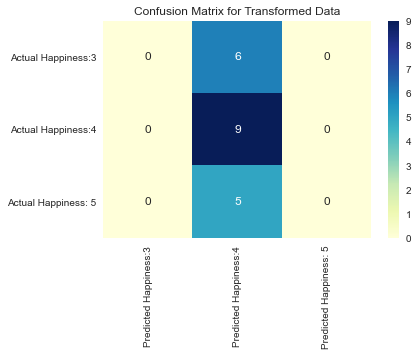

In [22]:
#confusion matrix for tranformed data
get_confusion_matrix(linear_svc, trans = True)

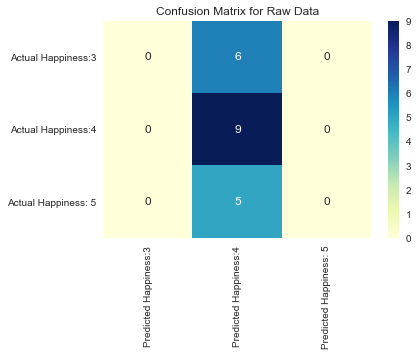

In [23]:
#confusion matrix for raw data
get_confusion_matrix(linear_svc, trans = False)

In a confusion matrix, we can see what the model predicted for the test data and what the actual value of the test data was. In both the raw and transformed, the model predicted *4* for the happiness of all test data. This confirms my previous assumption that both models are identical and explains why the test accuracies on both data sets are equal to the null accuracy (it is the null accuracy!).

In [24]:
#classification report
get_classification_report(linear_svc)

Classification Report for Transformed Data
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.45      1.00      0.62         9
           5       0.00      0.00      0.00         5

    accuracy                           0.45        20
   macro avg       0.15      0.33      0.21        20
weighted avg       0.20      0.45      0.28        20

Classification Report for Raw Data
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.45      1.00      0.62         9
           5       0.00      0.00      0.00         5

    accuracy                           0.45        20
   macro avg       0.15      0.33      0.21        20
weighted avg       0.20      0.45      0.28        20



**Precision**: the ratio of correctly classified data points to total number of data points predicted to be in that category; percentage of correct classifications to sum of column values in the confusion matrix; how good the model is at prediciting the correct class (the math on these are easy enough, so I don't think further explanation is necessary)

**Recall**: the ratio of correctly classified data point to toal number of actual data points in that category; percentage of correct classifications to sum of row values in the confusion matrix

**f1**: the weighted harmonic mean of precision and recall. So, f1-score is always lower than accuracy measures as they embed precision and recall into their computation. 

**Support**: simply the actual number of occurances of each class (level of happiness) in the actual dataset (y_test)

Both models just pick *4* for every test value, so the recall is going to be perfect in that category. Overall, this model isn't performing great as it has 0 precision, recall, and f1-score in anything that's not a *4*.

Precision Recall Curve for Transformed Data


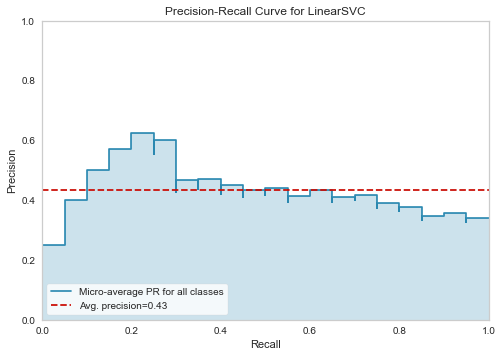

In [25]:
#PR curve on transformed data
print('Precision Recall Curve for Transformed Data')
precision_recall_curve(linear_svc, trans = True)

Precision Recall Curve for Raw Data


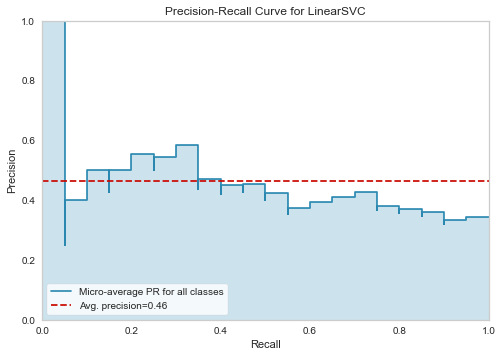

In [26]:
#PR curve on raw data
print('Precision Recall Curve for Raw Data')
precision_recall_curve(linear_svc, trans = False)

Precision-recall curves will plot precision vs recall. In a very good classifier, precision will be high at all recall values. These two models don't have high precisions at when we try to increase the recall (sensitivity). The red line is the average precision for all recall values. It can be seen that precision starts to fall below the average value as the recall is increased, showing that this model will output scores whose values are only slightly associated with the outcome. This isn't a sign of a good model. 

In [27]:
#10-fold cv mean accuracy
cv_scores(linear_svc)

CV Scores for Transformed Data: 
Cross-validation scores: [0.6  0.6  0.6  0.6  0.6  0.6  0.75 0.75 0.75 0.5 ]
Average cross-validation score: 0.635
CV Scores for Raw Data: 
Cross-validation scores: [0.6  0.6  0.6  0.6  0.6  0.6  0.75 0.75 0.75 0.5 ]
Average cross-validation score: 0.635


Using the mean cross-validation, we can conclude that we expect the model to be around 63.5 % accurate on average. If we look at all the 10 scores produced by the 10-fold cross-validation, we can also conclude that there is a relatively low variance in the accuracy between folds, ranging from 75% accuracy to 50% accuracy. Both models are the essentially the same, so that explains their same CV scores. When modeling to the other CV folds, our model improves at all 10 folds from its current state, meaning it begins to make other predicitions than just *4*. A 10-fold cross-validation accuracy results in about a 18% performance improvement for this model, on average.

#### Takeaways:

* The LinearSVC is essentially picking the most common value in the dataset for both the transformed and raw datasets, meaning it is no better than null accuracy and isn't making any real predicitions.
* This null accuracy model has a poor precision to recall relationship and loses much of its precision as it tries to increase recall.
* Overall, this isn't a very good model for either the transformed or the raw datasets, but a good case of seeing how the null accuracy case would perform.

### kNN Classifier

In [28]:
#K-Nearest Neighbors: Implements the K-Nearest neighbors vote
knn = KNeighborsClassifier()
score(knn)

Model Accuracy on Transformed Data: 0.4
Model Accuracy on Raw Data: 0.4


In [29]:
#check under/over fitting
fit_test(knn)

Transformed Data Scores:
Training set score: 0.6739130434782609
Test set score: 0.4

Raw Data Scores:
Training set score: 0.5869565217391305
Test set score: 0.4


For our fitness test, I am checking to see if the model is over/under fitted. Across both the transformed and raw data sets, the training test scores are much higher than the test set scores. This is especially true on the transformed data. The training set accuracies are about 25% and 18% greater than the test set accuracies: a sign of overfitting to the training data, especially on the transformed data.

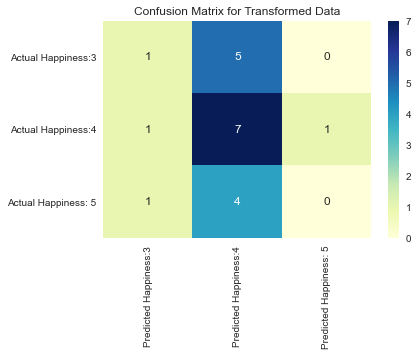

In [30]:
#confusion matrix for transformed data
get_confusion_matrix(knn, trans = True)

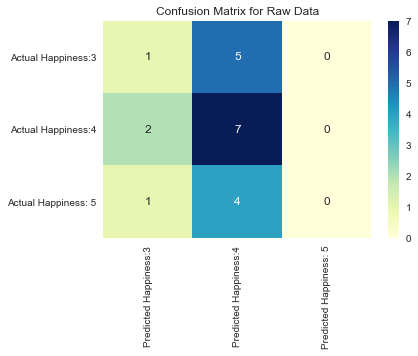

In [31]:
#confusion matrix for raw data
get_confusion_matrix(knn, trans = False)

In the transformed data, the model made a wider of variety picks, even prediciting a happiness of *5* once. It was still able to predict seven *4*'s and one *3*. The model on the raw data didn't make as wide of a variety of predicition, only predicting *3*'s and *4*'s, correctly matching one *3* and seven *4*'s.

In [32]:
#classification report
get_classification_report(knn)

Classification Report for Transformed Data
              precision    recall  f1-score   support

           3       0.33      0.17      0.22         6
           4       0.44      0.78      0.56         9
           5       0.00      0.00      0.00         5

    accuracy                           0.40        20
   macro avg       0.26      0.31      0.26        20
weighted avg       0.30      0.40      0.32        20

Classification Report for Raw Data
              precision    recall  f1-score   support

           3       0.25      0.17      0.20         6
           4       0.44      0.78      0.56         9
           5       0.00      0.00      0.00         5

    accuracy                           0.40        20
   macro avg       0.23      0.31      0.25        20
weighted avg       0.27      0.40      0.31        20



The transformed dataset model had a better average precision (0.26 vs 0.23 macro avg, 0.30 vs 0.27 weighted avg). The transformed dataset model had the same recall measurments as the raw dataset model. This signfies that both models correclty predicted the same values, but the transformed dataset model was a little more precise due to its more diverse predictions.

Precision Recall Curve for Transformed Data


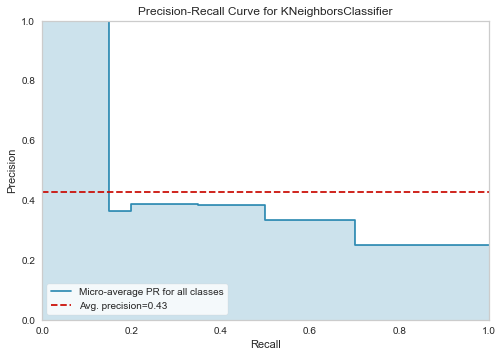

In [33]:
#PR curve on transformed data
print('Precision Recall Curve for Transformed Data')
precision_recall_curve(knn, trans = True)

Precision Recall Curve for Raw Data


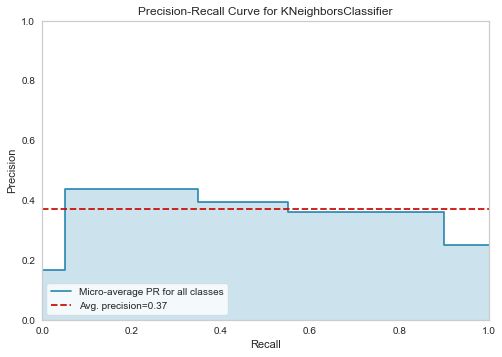

In [34]:
#PR curve on raw data
print('Precision Recall Curve for Raw Data')
precision_recall_curve(knn, trans = False)

These two models don't have high precisions at any recall (sensitivity) value greater than 0.2. The red line is the average precision for all recall values. It can be seen that precision in the transformed data model varies from the average precision by a lot more than the raw data model. However, the transformed data model has a greater maximum precision and a smaller minimum precision.

In [35]:
#10-fold cv mean accuracy
cv_scores(knn)

CV Scores for Transformed Data: 
Cross-validation scores: [0.6  0.4  0.8  0.6  0.4  0.6  0.5  0.75 0.75 0.5 ]
Average cross-validation score: 0.5900000000000001
CV Scores for Raw Data: 
Cross-validation scores: [0.4  0.4  0.2  0.4  0.6  0.6  0.75 0.75 0.75 0.5 ]
Average cross-validation score: 0.535


Using the mean cross-validation, we can conclude that we expect the model to be around 53.5-59 % accurate on average. If we look at all the 10 scores produced by the 10-fold cross-validation, we can also conclude that there is a decent variance in the accuracy between folds on the transforemd data model, ranging from 80% accuracy to 40% accuracy. However, for the model from the raw data, this variance is much greater, ranging from 75% accurate to 20% accurate on one fold. Regardless, a 10-fold CV accuracy results in a 14-19% performance improvement.

#### Takeaways:
* The transformed and raw data models correctly predicted the same number of data. However, the transformed dataset model made more diverse predictions, giving it a higher precision.
* Although neither model is better than null accuracy, I like how the kNN classifier on the transformed data turned out. It's precision-recall graph isn't great, but that could be fixed with some hyperparameter tuning.


### RandomForestClassifier

In [36]:
#RandomForestClassifier
rfc = RandomForestClassifier(random_state = 42)
score(rfc)

Model Accuracy on Transformed Data: 0.4
Model Accuracy on Raw Data: 0.45


In [37]:
#test under/over fit
fit_test(rfc)

Transformed Data Scores:
Training set score: 1.0
Test set score: 0.4

Raw Data Scores:
Training set score: 1.0
Test set score: 0.45


For our fitness test, I am checking to see if the model is over/under fitted. Across both the transformed and raw data sets, the training test scores are perfectly fit. However, the test set scores are 35% and 45% accurate, respectively. This shows the RandomForestClassifier is overfitting.

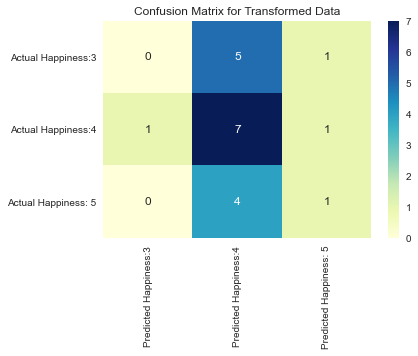

In [38]:
#confusion matrix on transformed data
get_confusion_matrix(rfc, trans = True)

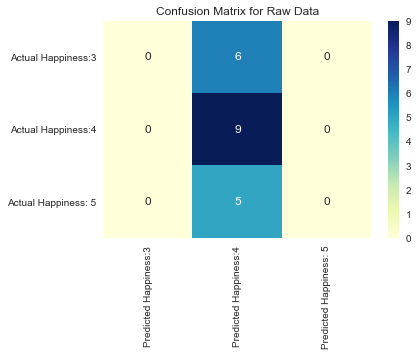

In [39]:
#confusion matrix on raw data
get_confusion_matrix(rfc, trans = False)

In the transformed data, the model made a wider of variety picks, even prediciting a happiness of *2* for one value. It's performance was very close to the kNN classifier fitted to the transformed data. However, the model fitted to the raw data simply predicited *4* for all test data, fitting to null accuracy and matching the LinearSVC models.

In [40]:
#classifcation report
get_classification_report(rfc)

Classification Report for Transformed Data
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.44      0.78      0.56         9
           5       0.33      0.20      0.25         5

    accuracy                           0.40        20
   macro avg       0.26      0.33      0.27        20
weighted avg       0.28      0.40      0.31        20

Classification Report for Raw Data
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.45      1.00      0.62         9
           5       0.00      0.00      0.00         5

    accuracy                           0.45        20
   macro avg       0.15      0.33      0.21        20
weighted avg       0.20      0.45      0.28        20



The transformed dataset model had a  better average precision (0.26 vs 0.15 macro avg, 0.28 vs 0.20 weighted avg). The transformed dataset model had lower average for weighted recall, but the same for macro average recall. This signfies that the transformed dataset model was a little more precise in its correct predicitions, but the raw dataset model is a little less sensitive. Neither model is ideal.

Precision Recall Curve for Transformed Data


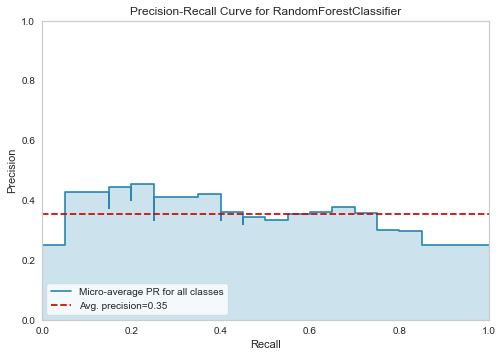

In [41]:
#PR curve on transformed data
print('Precision Recall Curve for Transformed Data')
precision_recall_curve(rfc, trans = True)

Precision Recall Curve for Raw Data


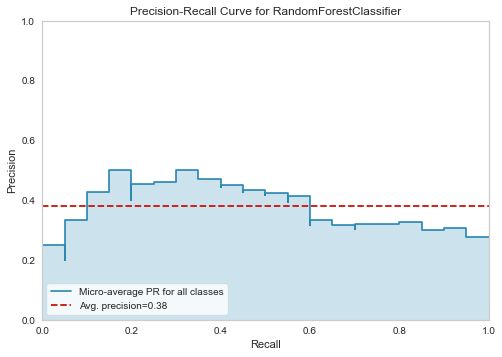

In [42]:
#PR curve on raw data
print('Precision Recall Curve for Raw Data')
precision_recall_curve(rfc, trans = False)

These two models don't have high precisions at any recall (sensitivity) value. The red line is the average precision for all recall values. It can be seen that precision in both models are very close to the average, although the raw dataset model has a little more variance.


In [43]:
#10-fold mean accuracy CV
cv_scores(rfc)

CV Scores for Transformed Data: 
Cross-validation scores: [0.6  0.6  0.8  0.6  0.6  0.6  0.75 0.75 0.75 0.75]
Average cross-validation score: 0.6799999999999999
CV Scores for Raw Data: 
Cross-validation scores: [0.4  0.4  0.6  0.6  0.6  0.6  0.5  0.5  0.75 0.5 ]
Average cross-validation score: 0.545


Using the mean cross-validation, we can conclude that we expect the model to be around 54.5-67.8 % accurate on average. If we look at all the 10 scores produced by the 10-fold cross-validation, we can also conclude that there is little variance in the accuracy between folds on the transforemd data model, ranging from 80% accuracy to 60% accurate. However, for the model from the raw data, this variance is marginally bigger, ranging from 75% accurate to 40% accurate. Regardless, a 10-fold CV accuracy results in about a 10-25% performance improvement.

#### Takeaways: 
* The transformed data model is making unqiue predictions while the raw data is just making null accuracy assumptions. The transformed data model matches the performance of the kNN classifier fit to the transformed data, while the raw data model matches the LinearSVC's in performance.

**Out of all the models created, I like the kNN classifier on the transformed dataset the best. It and the RandomForestClassifier on the transformed dataset are the only models that don't choose the null accuracy case. Between these two, the kNN has the potential to be a little more precise at higher sensitivities. So, with some hyperparameter tuning, I think the kNN classifier's performance can be improved even more.**

## 4. Hyperparameter Tuning

I will try to find the best values for the k-value, leaf_size, and p parameters of the kNN classifier using validation curves. By combining the best values from each of these curves (the ones that mainly optimize CV score while having a pretty high training score too), I hope to build a better kNN classifier.

First, k-value tuning:

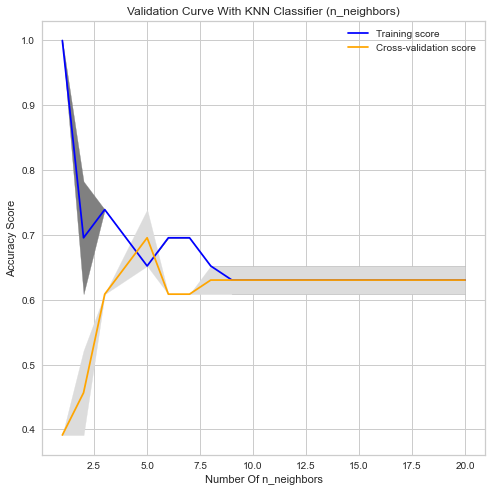

In [44]:
#tune k-value via validation curve
param_range = [1,2,3,5,6,7,8,9,10,20]
train_scoreNum, test_scoreNum = validation_curve(
                                KNeighborsClassifier(),
                                X = trans_X_train, y = y_train, 
                                param_name = 'n_neighbors', 
                                param_range = param_range, cv = 2)

train_mean = np.mean(train_scoreNum, axis = 1)
train_std = np.std(train_scoreNum, axis = 1)
test_mean = np.mean(test_scoreNum, axis = 1)
test_std = np.std(test_scoreNum, axis = 1)

plt.subplots(1, figsize=(7,7))
plt.plot(param_range, train_mean, label="Training score", color="blue")
plt.plot(param_range, test_mean, label="Cross-validation score", color="orange")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")
plt.title("Validation Curve With KNN Classifier (n_neighbors)")
plt.xlabel("Number Of n_neighbors")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

A k-value that is too high will result in the null accuracy case again, so we should try to avoid it. There is a peak arond n_neighbors = 5, but the model may be underfitting there. I think n_neighbors = 7 is a good start. 
Next, leaf_size:

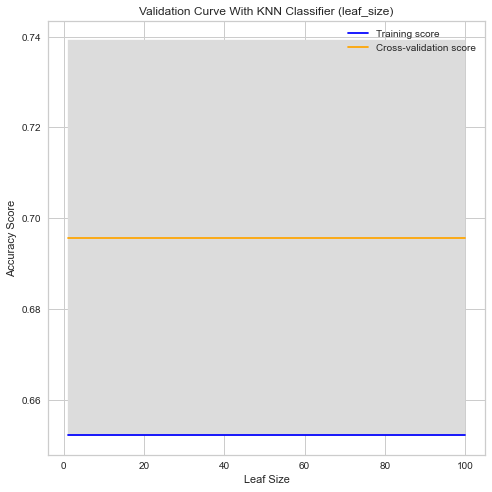

In [45]:
#tuning leaf_size with validation curve
param_range = [1,5,10,20,25,30,40,50,100]
train_scoreNum, test_scoreNum = validation_curve(
                                KNeighborsClassifier(),
                                X = trans_X_train, y = y_train, 
                                param_name = 'leaf_size', 
                                param_range = param_range, cv = 2)

train_mean = np.mean(train_scoreNum, axis = 1)
train_std = np.std(train_scoreNum, axis = 1)
test_mean = np.mean(test_scoreNum, axis = 1)
test_std = np.std(test_scoreNum, axis = 1)

plt.subplots(1, figsize=(7,7))
plt.plot(param_range, train_mean, label="Training score", color="blue")
plt.plot(param_range, test_mean, label="Cross-validation score", color="orange")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")
plt.title("Validation Curve With KNN Classifier (leaf_size)")
plt.xlabel("Leaf Size")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

It appears that leaf_size has no impact on model performance. However, CV score is much greater than training scores: a sign of possible underfitting. We will leave it alone.

Lastly, p:

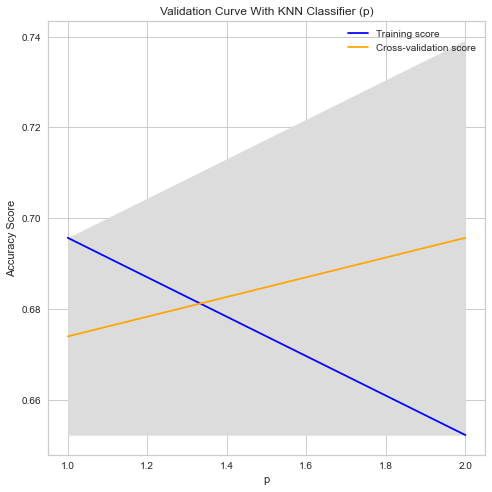

In [46]:
#tuning p with validation curve
param_range = [1,2]
train_scoreNum, test_scoreNum = validation_curve(
                                KNeighborsClassifier(),
                                X = trans_X_train, y = y_train, 
                                param_name = 'p', 
                                param_range = param_range, cv = 2)

train_mean = np.mean(train_scoreNum, axis = 1)
train_std = np.std(train_scoreNum, axis = 1)
test_mean = np.mean(test_scoreNum, axis = 1)
test_std = np.std(test_scoreNum, axis = 1)

plt.subplots(1, figsize=(7,7))
plt.plot(param_range, train_mean, label="Training score", color="blue")
plt.plot(param_range, test_mean, label="Cross-validation score", color="orange")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")
plt.title("Validation Curve With KNN Classifier (p)")
plt.xlabel("p")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

A p-parameter of 2 seems to perform pretty well. However, the standard deviations are quite vast, so it's difficult to tell how accurate this will be and the possibility of underfitting is possible. I will try p=2 for now. 

### Tuned kNN Classifier

In [47]:
#trying the tuned kNN
tuned_knn = KNeighborsClassifier(n_neighbors = 7, p = 2)
score(tuned_knn)

Model Accuracy on Transformed Data: 0.4
Model Accuracy on Raw Data: 0.5


In [48]:
#test over/under fit of tuned knn
fit_test(tuned_knn)

Transformed Data Scores:
Training set score: 0.6739130434782609
Test set score: 0.4

Raw Data Scores:
Training set score: 0.5869565217391305
Test set score: 0.5


The tuned model seems to have less of an overfitting problem as it has a smaller difference in training and test set scores. This is especially true for the raw data, which I think will perform quite well here.

*In the following confusion matrices, the untuned model is on top and the tuned model is on the bottom*

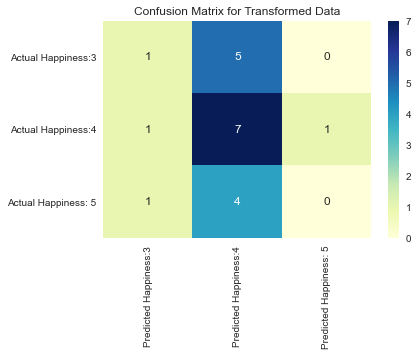

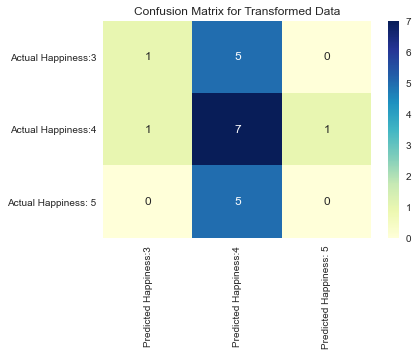

In [49]:
#compare confusion matrices on transformed data on untuned and tuned models
get_confusion_matrix(knn, trans = True)
get_confusion_matrix(tuned_knn, trans = True)

The tuned model and the untuned model make the same number and same set of correct predictions. The tuned model appears to rely much more heavily on the null accuracy case, predicting *4* more often than the untuned model. This is ok given the prevalance of a happiness level of *4* in the data.

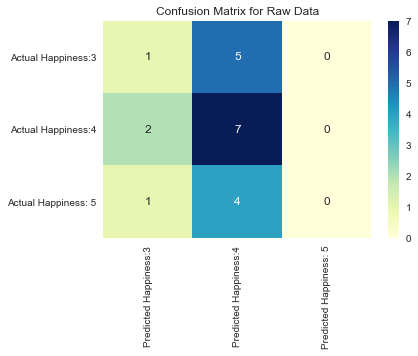

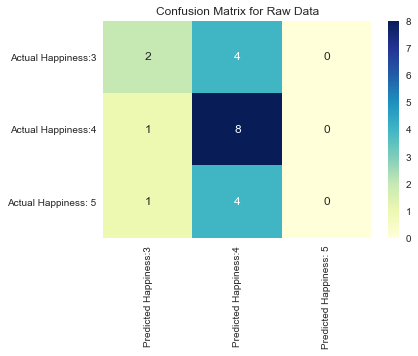

In [50]:
#compare confusion matrices on raw data on untuned and tuned models
get_confusion_matrix(knn, trans = False)
get_confusion_matrix(tuned_knn, trans = False)

On the raw data, the tuned model makes two more correct prediction, one at each *3* and *4* happiness level. The tuned model didn't rely any more heavily on the null accuracy case, instead, it seems it just made two better predictions.

In [51]:
#classification reports on untuned and tuned models
print('Untuned Model:')
get_classification_report(knn)
print('-'*60)
print('Tuned Model:')
get_classification_report(tuned_knn)

Untuned Model:
Classification Report for Transformed Data
              precision    recall  f1-score   support

           3       0.33      0.17      0.22         6
           4       0.44      0.78      0.56         9
           5       0.00      0.00      0.00         5

    accuracy                           0.40        20
   macro avg       0.26      0.31      0.26        20
weighted avg       0.30      0.40      0.32        20

Classification Report for Raw Data
              precision    recall  f1-score   support

           3       0.25      0.17      0.20         6
           4       0.44      0.78      0.56         9
           5       0.00      0.00      0.00         5

    accuracy                           0.40        20
   macro avg       0.23      0.31      0.25        20
weighted avg       0.27      0.40      0.31        20

------------------------------------------------------------
Tuned Model:
Classification Report for Transformed Data
              precision    r

Between the tuned and untuned models on the transformed data, the tuned models had better precision in both the transformed and raw data, and had the same or better recall than the untuned models. This is due to the fact that the tuned model made similar predictions to the untuned model, except for a few more correct decisions in the tuned model fit to the raw data.

Precision Recall Curve for Tuned Model fit to Transformed Data


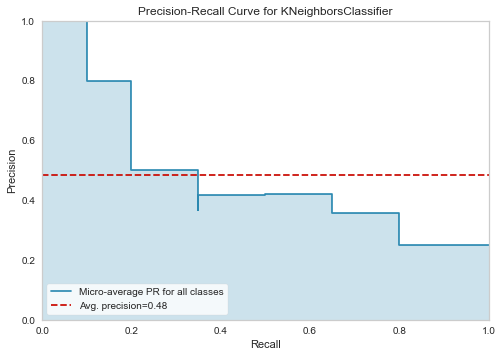

In [52]:
#PR curve on tuned model fit to transformed data
print('Precision Recall Curve for Tuned Model fit to Transformed Data')
precision_recall_curve(tuned_knn, trans = True)

Precision Recall Curve Tuned Model fit to Raw Data


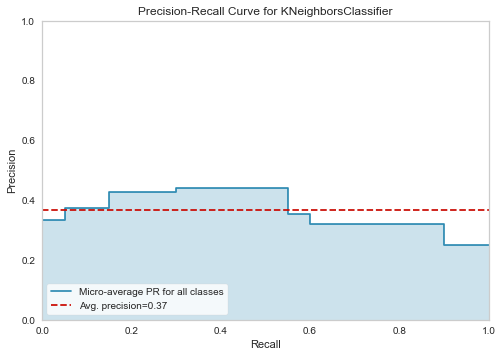

In [53]:
#PR curve on tuned model fit to raw data
print('Precision Recall Curve Tuned Model fit to Raw Data')
precision_recall_curve(tuned_knn, trans = False)

The tuned model's precision-recall curve on transformed data has much more variance than the model fit to raw data. The transformed model has the greater maximum and smaller minimum precision capacities, but neither performs with great accuracy.

In [54]:
#compare 10-fold mean accuracy CV of untuned and tuned models
print('Untuned Model:\n')
cv_scores(knn)
print('-'*60)
print('Tuned Model:\n')
cv_scores(tuned_knn)

Untuned Model:

CV Scores for Transformed Data: 
Cross-validation scores: [0.6  0.4  0.8  0.6  0.4  0.6  0.5  0.75 0.75 0.5 ]
Average cross-validation score: 0.5900000000000001
CV Scores for Raw Data: 
Cross-validation scores: [0.4  0.4  0.2  0.4  0.6  0.6  0.75 0.75 0.75 0.5 ]
Average cross-validation score: 0.535
------------------------------------------------------------
Tuned Model:

CV Scores for Transformed Data: 
Cross-validation scores: [0.6  0.4  0.8  0.6  0.6  0.6  1.   0.75 0.75 0.5 ]
Average cross-validation score: 0.6599999999999999
CV Scores for Raw Data: 
Cross-validation scores: [0.4  0.4  0.2  0.4  0.6  0.6  0.75 0.75 0.5  0.5 ]
Average cross-validation score: 0.51


Between the tuned and untuned model, the tuned model had beter CV scores for the transformed dataset, but not the raw dataset. In the transformed data, it had a 100% accurate fold and had a couple higher folds in the  raw data. Overall, the CV accuracy of the tuned model is mainly improved over a few folds in the transformed data, which probably have borderline datapoints. 10-fold CV accuracy will improve the performance of the model slightly.

#### Takeaways:
* The tuned model performed slightly better on the raw data, but pretty much the same as the untuned kNN on the transformed data. However, on the transformed data, the tuned model was less variable in its prediction, resulting in lower precision and f1 scores.
* Overall, the tuned model on the raw data was the one that performed the best in terms of accuracy, precision, and recall. It is the best model for this data, although none of these models fit the data with great accuracy.

## 5. Final Results and Conclusion
1. In this project, I built a LinearSVC, kNN classifier, and RandomForestClassifier to classify the the happiness of respondants in the dataset. Using a GP feature transformer, I also applied feature engineering to try and improve the performance of these classifiers. While this wasn't as succesful for the LinearSVC and RandomForestClassifier, it was slightly more succesful on the kNN classifier, which using base hyperparamters, wasn't the most accurate classifier, but showed the least sign of overfitting and didn't fall into null accuracy assumptions.


2. Tuning the kNN classifier created marginal improvements overall.


Overall, the model wasn't all too great. However, the EDA illustrated that the given features had very little to no correlation to happiness, so we couldn't expect a spectacular model. Feature engineering and transformation with the GP transformer didn't really make a difference, which I mainly attribute to the lack of correlation among features to the target and that the problem at hand wasn't binary classification. Given the loose correlations of the data, I think the tuned kNN classifier fit to the raw data is going to be as close as you can get to an accurate model.